In [56]:
#imports
import jax.numpy as np
import matplotlib.pyplot as plt
import pzflow
from pzflow import Flow
from pzflow.bijectors import Chain, ColorTransform, InvSoftplus, StandardScaler, RollingSplineCoupling, ShiftBounds
from pzflow.distributions import Uniform, Joint, Normal
import pandas as pd
import GCRCatalogs
import numpy as onp
import time
import seaborn as sns
start = time.process_time()

In [57]:
def f(logmass):
    return 2*logmass - 24

cosmo=GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_small")
#quantities = ['redshift', 'mag_true_g_lsst', 'mag_true_r_lsst', 'mag_true_i_lsst', 'mag_true_z_lsst', 'Mag_true_g_lsst_z0', 'Mag_true_r_lsst_z0', 'Mag_true_i_lsst_z0', 'Mag_true_z_lsst_z0', 
# 'stellar_mass', 'totalStarFormationRate']
quantities = ['redshift', 'Mag_true_g_lsst_z0', 'Mag_true_r_lsst_z0', 'Mag_true_i_lsst_z0', 'Mag_true_z_lsst_z0', 'stellar_mass', 'totalStarFormationRate']

print("Reading CosmoDC2 small catalog")
gal = cosmo.get_quantities(quantities)
print("Catalog read.")

Reading CosmoDC2 small catalog
Catalog read.


In [ ]:
# data_unscaled = {}
# data_unscaled['logSFRtot'] = np.log10(gal['totalStarFormationRate'])
# data_unscaled['redshift']  = gal['redshift']
# data_unscaled['logmass'] = np.log10(gal['stellar_mass'])
# data_unscaled['Mag_true_g_lsst_z0']  = gal['Mag_true_g_lsst_z0']
# data_unscaled['Mag_true_r_lsst_z0']  = gal['Mag_true_r_lsst_z0']
# data_unscaled['Mag_true_i_lsst_z0']  = gal['Mag_true_i_lsst_z0']
# data_unscaled['Mag_true_z_lsst_z0']  = gal['Mag_true_z_lsst_z0']
data_unscaled = pd.DataFrame(gal)
data_unscaled['logSFRtot'] = np.log10(data_unscaled['totalStarFormationRate'])
data_unscaled['logmass'] = np.log10(data_unscaled['stellar_mass'])
del gal

# data_unscaled['morphology/totalEllipticity'] = gal['morphology/totalEllipticity']

data_unscaled = pd.DataFrame(data_unscaled)

#get rid of that weird clump M* > 10^10 Msol and logSFR = -5
data_unscaled = data_unscaled[onp.asarray((data_unscaled['logSFRtot'] - 9) > f(data_unscaled['logmass']))]
#data_unscaled['g-r'] = data_unscaled['Mag_true_g_lsst_z0'] - data_unscaled['Mag_true_r_lsst_z0']
#data_unscaled['r-i'] = data_unscaled['Mag_true_r_lsst_z0'] - data_unscaled['Mag_true_i_lsst_z0']
#data_unscaled['i-z'] = data_unscaled['Mag_true_i_lsst_z0'] - data_unscaled['Mag_true_z_lsst_z0']

In [ ]:
# standard scale the reference magnitude and colors
#data = data_unscaled.copy()
for quality in ['logSFRtot', 'logmass', 'Mag_true_g_lsst_z0', 'Mag_true_r_lsst_z0', 'Mag_true_i_lsst_z0', 'Mag_true_z_lsst_z0']:#, 'g-r', 'r-i', 'i-z']:
    data_unscaled[quality] = (data_unscaled[quality]-data_unscaled[quality].mean())/data_unscaled[quality].std()

In [ ]:
# input - df: a Dataframe, chunkSize: the chunk size
# output - a list of DataFrame
# purpose - splits the DataFrame into smaller chunks
def split_dataframe(df, chunk_size = 10000): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

In [ ]:
# take a subset of 1/500th
# have tried 1/1000, 1/100,
data_subset = data_unscaled.sample(n=int(len(data_unscaled)/5.e2))

In [ ]:
print(data_subset)

In [ ]:
print('Training on {} CosmoDC2 galaxies.'.format(len(data_subset)))
conditional_columns = data_subset.columns.drop(['redshift'])#, 'logSFRtot'])
latent = Uniform((-5,5))#,(-5,5)) 
#means = np.array([data_subset['redshift'].mean(), data_subset['logSFRtot'].mean()])
#stds = np.array([data_subset['redshift'].std(), data_subset['logSFRtot'].std()]) #switched 1/6 to 1/5.9
mins = np.array([data_subset['redshift'].min()])
maxs = np.array([data_subset['redshift'].max()+0.1])
latent = Uniform((-5,5))
bijector = Chain(
    ShiftBounds(mins, maxs, 5),
    RollingSplineCoupling(nlayers=1, n_conditions=len(conditional_columns), K=2),
)

#bijector = Chain(
#    ShiftBounds(mins, maxs, 4.9),
#    RollingSplineCoupling(nlayers=1, n_conditions=len(conditional_columns)),#, K=2
#)

In [ ]:

# To create the conditional flow, we have to provide
# 1. The names of the data columns
# 2. The bijector
# 3. The names of the conditional columns

flow = Flow(
    data_columns = (["redshift"]), #, "logSFRtot"
    conditional_columns = conditional_columns,
    bijector = bijector,
    latent = latent,          
)

losses = flow.train(data_subset, epochs=30, verbose=True)

sns.set_context("talk")
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
#plt.savefig("../plots/pzflow_traning_loss.png")
## save the results, then apply them with the script apply_pzflow_dc2full.py
#flow.save('../data_files/pzflow_dc2small_nofilter_div500')
#print("CPU time taken: ", time.process_time() - start)

In [ ]:
allSamples = []
#split into 100 chunks
data_list = split_dataframe(data_subset, chunk_size=int(len(data_subset)/100.))

for chunk in data_list:
    samples = flow.sample(1, conditions=chunk.drop(columns=['redshift']), seed=0)
    allSamples.append(samples)
samples=pd.concat(allSamples)

In [ ]:
chunk

In [ ]:
data_subset['redshift_old'] = data_subset['redshift']
#data_subset['logSFRtot_old'] = data_subset['logSFRtot']

In [ ]:
data_subset['redshift_new'] = samples['redshift']
#data_subset['logSFRtot_new'] = samples['logSFRtot']

In [ ]:
plt.hist(data_subset['redshift_old'] - data_subset['redshift_new'], bins=np.linspace(-0.1, 0.1,50))

In [ ]:
data_subset

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(data_subset['redshift_new'], data_subset['Mag_true_g_lsst_z0'] - data_subset['Mag_true_r_lsst_z0'], 'o', ms=0.1)
plt.xlabel("DC2 Redshift")
plt.ylabel(r"$g-r$")

In [ ]:
lowz_pred = data_subset[data_subset['redshift_new'] < 0.1]
highz_pred = data_subset[data_subset['redshift_new'] > 3.0]
del lowz_pred['redshift_new']
del highz_pred['redshift_new']

In [ ]:
lowz_pred.drop(columns=['redshift_old'])

In [ ]:
lowz_new = flow.sample(1, conditions=lowz_pred.drop(columns=['redshift_old', 'redshift']), seed=0)
highz_new = flow.sample(1, conditions=highz_pred.drop(columns=['redshift_old', 'redshift']), seed=0)

Text(0, 0.5, '$g-r$')

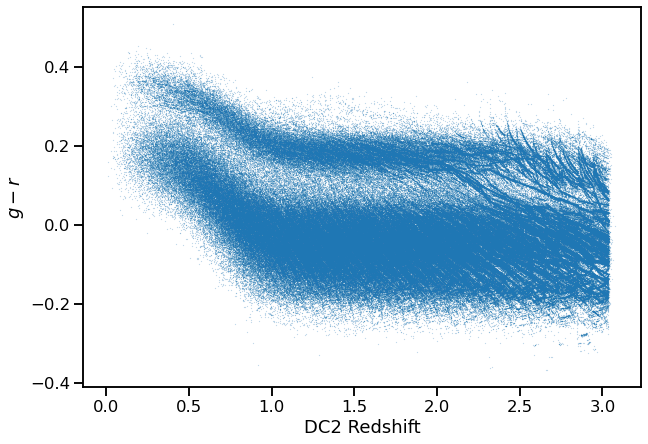

In [39]:
plt.figure(figsize=(10,7))
plt.plot(data_subset['redshift_old'], data_subset['Mag_true_g_lsst_z0'] - data_subset['Mag_true_r_lsst_z0'], 'o', ms=0.1)
plt.xlabel("DC2 Redshift")
plt.ylabel(r"$g-r$")

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(data_subset['redshift_old'], data_subset['Mag_true_r_lsst_z0'] - data_subset['Mag_true_i_lsst_z0'], 'o', ms=0.1)
plt.xlabel("DC2 Redshift")
plt.ylabel(r"$g-r$")

In [ ]:
#plt.figure(figsize=(10,7))
#plt.plot(data_subset['redshift_new'], data_subset['logSFRtot_new'], 'o', ms=0.3, alpha=0.3, label=r'pzflow')
##plt.plot(data_subset['redshift_old'], data_subset['logSFRtot_old'], 'o', ms=0.3, alpha=0.3, label=r'DC2')
#plt.legend(fontsize=16)
#plt.ylim((2, 10))
#plt.xlim((0, 3))
##plt.xlabel("DC2 Redshift")
#plt.xlabel("Redshift");
#plt.ylabel(r"logSFRtot");

In [ ]:
plt.figure(figsize=(10,7))
#plt.plot(data_subset['redshift_new'], data_subset['logSFRtot_new'], 'o', ms=0.3, alpha=0.3, label=r'pzflow')
plt.plot(data_subset['redshift_old'], data_subset['logSFRtot_old'], 'o', ms=0.3, alpha=0.3, label=r'DC2')
plt.legend(fontsize=16)
plt.ylim((2, 10))
plt.xlim((0, 3))
#plt.xlabel("DC2 Redshift")
plt.xlabel("Redshift");
plt.ylabel(r"SFR");

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(data_subset['redshift_new'], data_subset['g-r'], 'o', ms=0.5, alpha=0.3, label=r'pzflow')
plt.plot(data_subset['redshift_old'], data_subset['g-r'], 'o', ms=0.5, alpha=0.3, label=r'DC2')
#plt.xlabel("DC2 Redshift")
plt.xlabel("Redshift");
plt.ylabel(r"$g-r$");

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(data_subset['redshift_old'], data_subset['redshift_new'] - data_subset['redshift_old'], 'o', ms=1)
plt.xlabel(r"$z_{\rm pzflow}$")
plt.ylim((-0.5, 0.5))
plt.axhline(y=0, ls='--', c='tab:red')
plt.ylabel(r"$z_{\rm pzflow} - z_{\rm DC2}$");

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(data_subset['logSFRtot_old'], (data_subset['logSFRtot_new'] - data_subset['logSFRtot_old'])/data_subset['logSFRtot_old'], 'o', ms=1)
plt.xlabel(r"$logSFRtot_{\rm pzflow}$")
plt.ylim((-1, 1))
plt.xlim((2, 11))
plt.axhline(y=0, ls='--', c='tab:red')
plt.ylabel(r"($logSFRtot_{\rm pzflow} - logSFRtot_{\rm DC2}$)/$logSFRtot_{\rm DC2}$");

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(data_subset['redshift_new'], data_subset['logSFRtot_new'] - data_subset['logSFRtot_old'], 'o', ms=1)
plt.xlabel(r"$z_{\rm pzflow}$")
#plt.xlim((2, 10))
plt.ylim((-3, 3))
plt.axhline(y=0, ls='--', c='tab:red')
plt.ylabel(r"$logSFRtot_{\rm pzflow} - logSFRtot_{\rm DC2}$");